# LoFi on logistic regression

In [61]:
import jax
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp

from jax.flatten_util import ravel_pytree
from rebayes.datasets import datasets
from rebayes.low_rank_filter import lofi

In [14]:
%config InlineBackend.figure_format = "retina"

<AxesSubplot: ylabel='Count'>

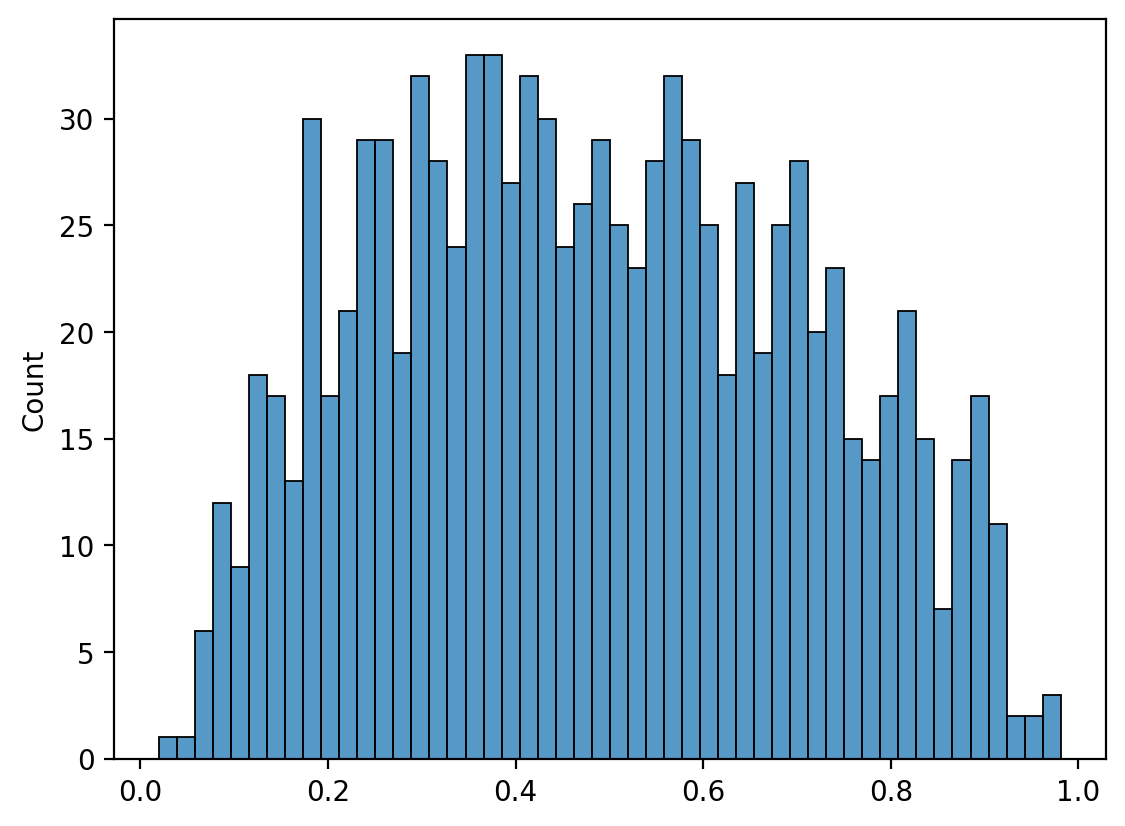

In [53]:
num_train = 1_000
num_test = 1_000
num_features = 150

dgenerator = datasets.LRDataset(
    dim_inputs=num_features,
    sigma=1.0,
    scale=4.0,
    condition_number=1.0
)

key = jax.random.PRNGKey(314)
key_train, key_test, key_model = jax.random.split(key, 3)

gstate, (X_train, y_train) = dgenerator.sample_train(key_train, num_train)
X_test, y_test = dgenerator.sample_test(key_test, gstate, 1_000)

y_train = jax.nn.sigmoid(y_train)
y_test = jax.nn.sigmoid(y_test)

sns.histplot(y_train, bins=50)

In [56]:
class LogReg(nn.Module):
    n_out: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_out)(x)
        return x

In [63]:
model = LogReg(1)
params_init = model.init(key_model, X_train)
params_init, rfn = ravel_pytree(params_init)

In [66]:
def meanfn(w, x):
    log_mu = model.apply(rfn(w), x)
    mu = jax.nn.sigmoid(log_mu)
    return mu

def covfn(w, x):
    mu = meanfn(w, x)
    return mu * (1 - mu)

In [67]:
?lofi.RebayesLoFiDiagonal

Init signature:
lofi.RebayesLoFiDiagonal(
    dynamics_weights: Union[float, jaxtyping.Float[Array, 'dim'], jaxtyping.Float[Array, 'dim dim']],
    dynamics_covariance: Union[float, jaxtyping.Float[Array, 'dim'], jaxtyping.Float[Array, 'dim dim']],
    emission_mean_function: Union[Callable[[jaxtyping.Float[Array, 'state_dim']], jaxtyping.Float[Array, 'emission_dim']], Callable[[jaxtyping.Float[Array, 'state_dim'], jaxtyping.Float[Array, 'input_dim']], jaxtyping.Float[Array, 'emission_dim']]],
    emission_cov_function: Union[Callable[[jaxtyping.Float[Array, 'state_dim']], jaxtyping.Float[Array, 'emission_dim emission_dim']], Callable[[jaxtyping.Float[Array, 'state_dim'], jaxtyping.Float[Array, 'input_dim']], jaxtyping.Float[Array, 'emission_dim emission_dim']]],
    emission_dist: Callable[[jaxtyping.Float[Array, 'state_dim'], jaxtyping.Float[Array, 'state_dim state_dim']], tensorflow_probability.substrates.jax.distributions.distribution.Distribution] = <function RebayesLoFiDiagonal.<

In [70]:
tfd = tfp.distributions

In [71]:
agent = lofi.RebayesLoFiDiagonal(
    dynamics_weights=1.0,
    dynamics_covariance=1e-6,
    emission_mean_function=meanfn,
    emission_cov_function=covfn,
    emission_dist=lambda mean, cov: tfd.Bernoulli(loc=mean)
)

In [75]:
bel, hist = agent.scan(
    params_init, 0.1, X_train, y_train, progress_bar=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]